In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from cca import kron_pca
from cca import synth_data

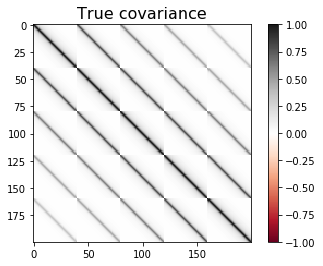

In [8]:
#Make a Kernel and compute true covariance matrix

N = 40
num_lags = 5

K_1 = synth_data.gen_gp_kernel(kernel_type="squared_exp", spatial_scale=2.0, temporal_scale=5.0)
K_2 = synth_data.gen_gp_kernel(kernel_type="exp", spatial_scale=5.0, temporal_scale=2.0)
def K(t1, t2, x1, x2):
    return (K_1(t1, t2, x1, x2) + K_2(t1, t2, x1, x2))/2

true_cov = synth_data.gen_gp_cov(num_lags, N, K)

plt.imshow(true_cov, vmin=-1, vmax=1, cmap="RdGy")
plt.colorbar()
plt.title("True covariance", fontsize=16)
plt.show()

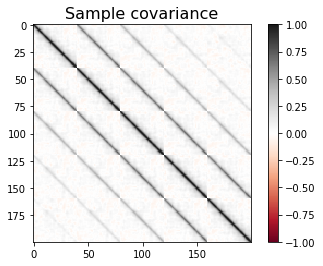

In [9]:
#Generate finite data from the Kernel

num_samples = 500
X = synth_data.sample_gp(kernel=K, T=num_lags, N=N, num_to_concat=num_samples)

#Compute sample covariance matrix

skip = 1
n = int(np.floor((len(X)-num_lags+1)/skip))
X_with_lags = np.zeros((n, N*num_lags))
X_centered = X - X.mean(axis=0)
for i in range(n):
    X_with_lags[i, :] = X_centered[i*skip:i*skip+num_lags].flatten()
    
sample_cov = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)

plt.imshow(sample_cov, vmin=-1, vmax=1, cmap="RdGy")
plt.colorbar()
plt.title("Sample covariance", fontsize=16)
plt.show()

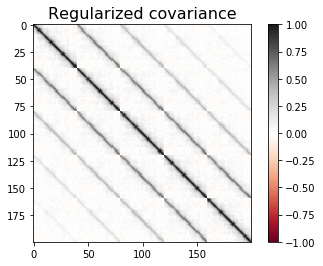

0.012862374681201836


In [11]:
#Compute regularized covariance estaimte using Kron PCA for block Toeplitz matrices
#(hyperparameters set by hand here)

lambda_L = 0.5689866029018299
lambda_S = 1e6
num_iter = 100
tau = 0.1

cov_reg, _, _ = kron_pca.prox_grad_robust_toeplitz_kron_pca(sample_cov, N, num_lags, lambda_L, lambda_S, num_iter, tau, return_rank_and_sparsity=True)

plt.imshow(cov_reg, vmin=-1, vmax=1, cmap="RdGy")
plt.colorbar()
plt.title("Regularized covariance", fontsize=16)
plt.show()

w, V = scipy.linalg.eigh(cov_reg)
print(np.min(w))

In [13]:
def cv_log_likelihood(X, k, est_cov_fn):
    
    fold_size = int(np.floor(len(X)/k))
    log_likelihood_vals = np.zeros(k)
    rank_vals = np.zeros(k)
    d = X.shape[1]
    
    for cv_iter in range(k):
        
        X_train = np.concatenate((X[:cv_iter*fold_size], X[(cv_iter+1)*fold_size:]), axis=0)
        X_test = X[cv_iter*fold_size : (cv_iter+1)*fold_size]
                        
        X_train_centered = X_train - X_train.mean(axis=0)
        X_test_centered = X_test - X_test.mean(axis=0)
        
        cov_train = np.dot(X_train_centered.T, X_train_centered)/len(X_train_centered)
        cov_test = np.dot(X_test_centered.T, X_test_centered)/len(X_test_centered)
        
        cov_reg_train, rank = est_cov_fn(cov_train)
        
        _, log_det_cov_reg_train = np.linalg.slogdet(cov_reg_train)
        cov_reg_train_inv = np.linalg.inv(cov_reg_train)
        
        N = len(X_test) #N = number of samples, here
        log_likelihood = -0.5*N*d*np.log(2*np.pi) - 0.5*N*log_det_cov_reg_train - 0.5*N*np.trace(np.dot(cov_reg_train_inv, cov_test))
        
        log_likelihood_vals[cv_iter] = log_likelihood
        rank_vals[cv_iter] = rank
        
    return log_likelihood_vals, rank_vals

        
        

In [14]:
lambda_L_vals = np.logspace(-3, 2, 50)
lambda_S = 1e7
num_folds = 10
num_iter = 200
tau = 0.25

cv_log_likelihood_vals = np.zeros(len(lambda_L_vals))
cv_rank_vals = np.zeros(len(lambda_L_vals))

for lambda_L_idx in range(len(lambda_L_vals)):
    
    print(lambda_L_idx)
    lambda_L = lambda_L_vals[lambda_L_idx]
    
    def est_cov_fn(sample_cov):
        cov_reg, rank, _ = kron_pca.prox_grad_robust_toeplitz_kron_pca(sample_cov, N, num_lags, lambda_L, lambda_S, num_iter, tau, return_rank_and_sparsity=True)
        return cov_reg, rank

    log_likelihood_vals, rank_vals = cv_log_likelihood(X_with_lags, num_folds, est_cov_fn)
    cv_log_likelihood_vals[lambda_L_idx] = log_likelihood_vals.mean()
    cv_rank_vals[lambda_L_idx] = np.median(rank_vals)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


LinAlgError: Singular matrix

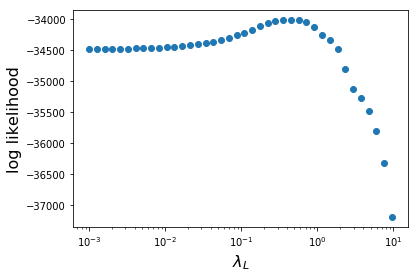

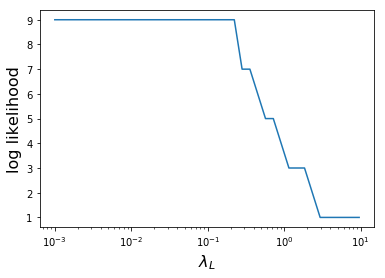

In [15]:
plt.xscale("log")
plt.scatter(lambda_L_vals[:40], cv_log_likelihood_vals[:40])
plt.ylabel("log likelihood", fontsize=16)
plt.xlabel("$\lambda_L$", fontsize=16)
plt.show()

plt.xscale("log")
plt.plot(lambda_L_vals[:40], cv_rank_vals[:40])
plt.ylabel("log likelihood", fontsize=16)
plt.xlabel("$\lambda_L$", fontsize=16)
plt.show()

In [16]:
"""
need to handle the case where the covariance matrix is null
This just means that lambda_L is too big...
so stop the optimization there...
Actually, that would be a good termination condition...

CV params:
tolerance
num_folds
lambda_L_min
lambda_L_ratio
tau



"""

lambda_L = lambda_L_vals[np.argmax(cv_log_likelihood_vals[:40])]
print(lambda_L)

0.35564803062231287


In [17]:
lambda_L_vals[1:]/lambda_L_vals[:-1]

array([1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522, 1.26485522,
       1.26485522, 1.26485522, 1.26485522, 1.26485522])